In [1]:
# !pip install -U kaleido
import pandas as pd
import numpy as np
from pathlib import Path
from functools import reduce
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, k_means
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import xgboost as xgb

import plotly.express as px
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import SCORERS

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# To reset the option to its default value (e.g., to limit output again), you can use:
# pd.reset_option('display.max_rows')

## Preprocessing

In [2]:
TIME_FORMAT = '%Y-%m-%d'
DROPNA = False
key_columns = ['locus_id', 'fish_group_id', 'transfer_year']

root_path = Path('../data/')

targets = pd.read_csv(root_path / 'targets.csv')

mortality = pd.read_csv('../data/smolt_dataset_transfers.csv') #_until2023Feb28_narrow
mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
mortality['transport_year']= mortality['transfer_date'].dt.year

#tgc = pd.read_csv('../data/transfers_until2023Feb28_with_sw_growth_targets.csv')
img_path = Path('./img')
result_data_path = Path('./result_data')
img_path.mkdir(exist_ok=True)
result_data_path.mkdir(exist_ok=True)

In [3]:
factors_ammonium = pd.read_csv(root_path / 'factors_ammonium_UPD.csv')
features_ammonium = ['ammonium-4_weeks_before_transfer-std',
                     'ammonium-8_weeks_before_transfer-max',
                     'ammonium-2_weeks_before_transfer-mean',
                     'ammonium-4_weeks_before_transfer-cv',
                     'ammonium-6_weeks_before_transfer-relative_higher_max-1']
factors_ammonium = factors_ammonium[key_columns + features_ammonium]

In [4]:
factors_ammonium.columns

Index(['locus_id', 'fish_group_id', 'transfer_year',
       'ammonium-4_weeks_before_transfer-std',
       'ammonium-8_weeks_before_transfer-max',
       'ammonium-2_weeks_before_transfer-mean',
       'ammonium-4_weeks_before_transfer-cv',
       'ammonium-6_weeks_before_transfer-relative_higher_max-1'],
      dtype='object')

In [5]:
factors_luf = pd.read_csv(root_path / 'feed_luf_factors.csv')
features_luf = ['is_luf_weighted']
factors_luf = factors_luf[key_columns + features_luf]

In [6]:
factors_luf.columns

Index(['locus_id', 'fish_group_id', 'transfer_year', 'is_luf_weighted'], dtype='object')

In [7]:
factors_feed_1 = pd.read_csv(root_path / 'significant_factors_feed_part1.csv')
features_feed_1 = ['lower_mean_days_coef=0.33',
                  'drop_count_coef=0.5']
factors_feed_1 = factors_feed_1[key_columns + features_feed_1]

factors_feed_2 = pd.read_csv(root_path / 'significant_factors_feed_part2.csv')
features_feed_2 = ['eight_last_weeks-tgc']
factors_feed_2 = factors_feed_2[key_columns + features_feed_2]

factors_feed_3 = pd.read_csv(root_path / 'significant_factors_feed_part3.csv')
features_feed_3 = ['eight_last_weeks-fcr',
                 'eight_last_weeks-sfr']
factors_feed_3 = factors_feed_3[key_columns + features_feed_3]

In [8]:
factors_feed_1.columns

Index(['locus_id', 'fish_group_id', 'transfer_year',
       'lower_mean_days_coef=0.33', 'drop_count_coef=0.5'],
      dtype='object')

In [9]:
factors_feed_2.columns

Index(['locus_id', 'fish_group_id', 'transfer_year', 'eight_last_weeks-tgc'], dtype='object')

In [10]:
factors_feed_3.columns

Index(['locus_id', 'fish_group_id', 'transfer_year', 'eight_last_weeks-fcr',
       'eight_last_weeks-sfr'],
      dtype='object')

In [11]:
factors_mortality = pd.read_csv(root_path / 'factors_mortality_rate_no_productiva.csv') #_UPD
features_mortality = ['mortality_rate-6_weeks_before_transfer-sum']
factors_mortality = factors_mortality[key_columns + features_mortality]

factors_mortality_reasons = pd.read_csv(root_path / 'factors_mortality_rate_Desadaptado.csv')
features_mortality_reasons = ['mortality_rate-after_first_feeding-sum',
                              #'mortality_rate-whole_period-sum_Eliminación Deforme',
                              #'mortality_rate-whole_period-sum_Eliminación Plateado',
                              #'mortality_rate-whole_period-sum_Eliminación Opérculo',
                              #'mortality_rate-whole_period-sum_Embrionaria'
                             ]
factors_mortality_reasons = factors_mortality_reasons[key_columns + features_mortality_reasons]
factors_mortality_reasons = factors_mortality_reasons.rename({'mortality_rate-after_first_feeding-sum': 'mortality_rate-after_first_feeding-sum_Desadaptado'}, axis=1)

In [12]:
factors_mortality_reasons['transfer_year'].value_counts()

transfer_year
2019    276
2018    232
2017    224
2020    214
2023    183
2021    154
2022    124
Name: count, dtype: int64

In [13]:
factors_mortality.columns

Index(['locus_id', 'fish_group_id', 'transfer_year',
       'mortality_rate-6_weeks_before_transfer-sum'],
      dtype='object')

In [14]:
factors_mortality_reasons.columns

Index(['locus_id', 'fish_group_id', 'transfer_year',
       'mortality_rate-after_first_feeding-sum_Desadaptado'],
      dtype='object')

In [15]:
factors_producer = pd.read_csv(root_path / 'feed_producer_significant_factors.csv')
features_producer = ['weight_BI']
factors_producer = factors_producer[key_columns + features_producer]

In [16]:
factors_producer.columns

Index(['locus_id', 'fish_group_id', 'transfer_year', 'weight_BI'], dtype='object')

In [17]:
factors_ph = pd.read_csv(root_path / 'significant_factors_ph_smoothed.csv')
features_ph = ['ph-8_weeks_before_transfer-std',
#                'ph-8_weeks_before_transfer-max', #removed because of low interpretability
               'ph-8_weeks_before_transfer-relative_higher_max-7.3',
               'ph-8_weeks_before_transfer-relative_lower_min-6.9',
               'ph-transfer_vaccination-std']
factors_ph = factors_ph[key_columns + features_ph]

In [18]:
factors_ph.columns

Index(['locus_id', 'fish_group_id', 'transfer_year',
       'ph-8_weeks_before_transfer-std',
       'ph-8_weeks_before_transfer-relative_higher_max-7.3',
       'ph-8_weeks_before_transfer-relative_lower_min-6.9',
       'ph-transfer_vaccination-std'],
      dtype='object')

In [19]:
factors_recambio = pd.read_csv(root_path / 'significant_factors_recambio_UPD.csv')
features_recambio = ['recambio-transfer_vaccination-std',
                     'recambio-vaccination_transfer-relative_lower_min-25',
                     'recambio-transfer_vaccination-max']
factors_recambio = factors_recambio[key_columns + features_recambio]

In [20]:
factors_recambio.columns

Index(['locus_id', 'fish_group_id', 'transfer_year',
       'recambio-transfer_vaccination-std',
       'recambio-vaccination_transfer-relative_lower_min-25',
       'recambio-transfer_vaccination-max'],
      dtype='object')

In [21]:
factors_sfr = pd.read_csv(root_path / 'factors_sfr.csv') #significant__UPD
# features_sfr = ['sfr-first_feeding_transfer-relative_lower_min-0.01']
features_sfr = [
#        'sfr-first_feeding_transfer-relative_lower_min-0.01',
       #'sfr-2_weeks_before_transfer-relative_lower_min-0.01',
       #'sfr-4_weeks_before_transfer-relative_lower_min-0.01',
        'sfr-6_weeks_before_transfer-relative_lower_min-0.01',
#        'sfr-8_weeks_before_transfer-relative_lower_min-0.01',
#        'sfr-vaccination_transfer-relative_lower_min-0.01'
]
factors_sfr = factors_sfr[key_columns + features_sfr]

#Dmitrii: I have no idea why there is no sfr-4 in SFR factors, so selecting sfr-6 is just as similar to it
factors_sfr = factors_sfr.rename({'sfr-6_weeks_before_transfer-relative_lower_min-0.01': 'sfr-4_weeks_before_transfer-relative_lower_min-0.01'},axis=1)

In [22]:
factors_sfr.columns

Index(['locus_id', 'fish_group_id', 'transfer_year',
       'sfr-4_weeks_before_transfer-relative_lower_min-0.01'],
      dtype='object')

In [23]:
factors_temperature = pd.read_csv(root_path / 'significant_factors_temperature.csv') #_UPD
factors_temperature2 = pd.read_csv(root_path / 'significant_factors_temperature_hatching.csv')
factors_temperature = factors_temperature.merge(factors_temperature2, how='outer')

features_temperature = ['temperature_fw_sw_diff',
                        'temperature_cleared-before_first_feeding-mean',
                        'temperature_cleared-before_first_feeding-degree_days',
                       ]
factors_temperature = factors_temperature[key_columns + features_temperature]

In [24]:
factors_temperature.columns

Index(['locus_id', 'fish_group_id', 'transfer_year', 'temperature_fw_sw_diff',
       'temperature_cleared-before_first_feeding-mean',
       'temperature_cleared-before_first_feeding-degree_days'],
      dtype='object')

In [25]:
factors_treatment = pd.read_csv(root_path / 'factors_treatments.csv') #_normalized
features_treatment = [
    'is_nacl_weighted-after_first_feeding-sum',
    'is_nacl_weighted-whole_period-sum',
    'is_bronopol_weighted-whole_period-sum',
    'is_cloramina t_weighted-whole_period-sum'
] #From feature importances

# features_treatment = [
#     'is_baño sin pmv-after_first_feeding-sum',
#     'is_baño sin pmv-whole_period-sum',
#     'is_bath-after_first_feeding-sum',
#     'is_bath-whole_period-sum',
#     'is_ipn-whole_period-sum',
#     'is_nacl-after_first_feeding-sum',
#     'is_nacl-whole_period-sum',
#     'is_saprosafe aw-whole_period-sum',
#     'is_cloramina t-whole_period-sum',
# #     'is_lufenurón-whole_period-sum', #we have similar 'is_luf_weighted' feature from feed data source
#     'is_bronopol-whole_period-sum',
# ]
factors_treatment = factors_treatment[key_columns + features_treatment]
factors_treatment = factors_treatment.rename({
    'is_nacl_weighted-after_first_feeding-sum': 'is_nacl-after_first_feeding-sum',
    'is_nacl_weighted-whole_period-sum': 'is_nacl-whole_period-sum',
    'is_bronopol_weighted-whole_period-sum': 'is_bronopol-whole_period-sum',
    'is_cloramina t_weighted-whole_period-sum': 'is_cloramina t-whole_period-sum',
    'is_Lufenurón_weighted': 'is_luf_weighted'
},axis=1)




In [26]:
factors_photoperiod = pd.read_csv(root_path / 'significant_factors_photoperiod_UPD.csv')
features_photoperiod = [ 
    'light_days_transfer_vaccination',
    'av.light_hours_per_day_vac',
    'number_of_weeks_with_summer_vac_transfer_normalized',
    'number_of_weeks_with_summer_vac_transfer'

]
factors_photoperiod = factors_photoperiod[key_columns + features_photoperiod]

In [27]:
factors_cycle = pd.read_csv(root_path / 'factors_cycle.csv')
factors_cycle['fw_cycle_length_first_mvmt_first_feeding']=factors_cycle['fw_cycle_length_first_mvmt_shipout']-factors_cycle['fw_cycle_length_first_feeding_shipout']
features_cycle = [
#     'fw_cycle_length_vac_shipout', #we have similar "vac_conf_transfer_days"
    #'ups_length',
    'fw_cycle_length_first_mvmt_shipout',
    'fw_cycle_length_first_feeding_shipout',
    'fw_cycle_length_first_mvmt_first_feeding'
]
factors_cycle = factors_cycle[key_columns + features_cycle]

In [28]:
factors_transfer = pd.read_csv(root_path / 'factors_transfer.csv')
factors_transfer = factors_transfer.merge(
    mortality[key_columns+['days_btw_to_from']],
    how='left'
)
features_transfer = [
'to_avg_weight','density_FW','days_btw_to_from'#,'Dec-Feb','Jun-Aug','Mar-May','Sep-Nov'
]
factors_transfer = factors_transfer[key_columns + features_transfer]

In [29]:
factors_lab = pd.read_csv(root_path / 'factors_lab.csv')
factors_lab = factors_lab.merge(
    factors_producer[key_columns],
    left_on=['to_locus_id', 'to_fish_group_id'],
    right_on=['locus_id', 'fish_group_id']
)
features_lab = [
    #'atpasa_last',
    #'k_factor_last',
    'atpasa_derivative',
    #'k_factor_derivative',
    #'length_last',
    #'weight_last'
]
factors_lab = factors_lab[key_columns + features_lab]

In [30]:
factors_vaccination = pd.read_csv(root_path / 'significant_factors_vaccination.csv')
features_vaccination = [
'vac_weight','vac_uta','vac_fish_count_mean','vac_conf_transfer_days','vac_conf_days'
]
factors_vaccination = factors_vaccination[key_columns + features_vaccination]

In [31]:
factors_vaccination.columns

Index(['locus_id', 'fish_group_id', 'transfer_year', 'vac_weight', 'vac_uta',
       'vac_fish_count_mean', 'vac_conf_transfer_days', 'vac_conf_days'],
      dtype='object')

In [32]:
factors_biofilter = pd.read_csv(root_path / 'factors_biofilter.csv')
features_biofilter = [
    'is_cleaned_mean',
    'is_desinfected_mean'
]
factors_biofilter = factors_biofilter[key_columns + features_biofilter]

factors_biofilter = pd.read_csv(root_path / 'factors_biofilter.csv')
features_biofilter = [
    'is_cleaned_mean',
    'is_desinfected_mean'
]
factors_biofilter = factors_biofilter[key_columns + features_biofilter]

In [33]:
factors_gender = pd.read_csv(root_path / 'factors_gender_dom.threshold=0.95.csv')
factors_gender=pd.concat([factors_gender.drop(columns=['main_gender','dominating_gender']),pd.get_dummies(factors_gender[['main_gender','dominating_gender']])],axis=1)
features_gender = [
'weight_H', 'weight_M',
       'main_gender_H', 'main_gender_M', 'dominating_gender_H',
       'dominating_gender_M', 'dominating_gender_non_existing'
]
factors_gender = factors_gender[key_columns + features_gender]

In [34]:
factors_gender.columns

Index(['locus_id', 'fish_group_id', 'transfer_year', 'weight_H', 'weight_M',
       'main_gender_H', 'main_gender_M', 'dominating_gender_H',
       'dominating_gender_M', 'dominating_gender_non_existing'],
      dtype='object')

In [35]:
# nan_idxs = factors_mortality_reasons[
#     factors_mortality_reasons.isna()['mortality_rate-after_first_feeding-sum_Desadaptado']
# ].index

factors_dfs = {
    'nh4': factors_ammonium,
    'cycle': factors_cycle,
    'transfer': factors_transfer,
    'feed_1': factors_feed_1,
    'feed_2': factors_feed_2,
    'feed_3': factors_feed_3,
    'lab': factors_lab,
    'luf': factors_luf,
    'mortality': factors_mortality,
    'mortality_reasons': factors_mortality_reasons,
    'ph': factors_ph,
    'photoperiod': factors_photoperiod,
    'producer': factors_producer,
    'recambio': factors_recambio,
    'sfr': factors_sfr,
    'temperature': factors_temperature,
    'treatment': factors_treatment,
    'vaccination':factors_vaccination,
    'biofilter': factors_biofilter,
    'gender': factors_gender
}

nan_data = {'source': [], 'max_nan_feature': [], 'nan_count': [], 'sample_count': []}

for title, df in factors_dfs.items():
    max_nan_feature = df.isna().sum()[df.isna().sum() == df.isna().sum().max()].index[-1]
    nan_count = df.isna().sum().max()
    sample_count = df.shape[0]
#     print(f'{title.capitalize()}:', max_nan_feature, end='; ')
#     print('nan count:', nan_count, end=' ')
#     print('out of ', sample_count)
    
    nan_data['source'].append(title)
    nan_data['max_nan_feature'].append(max_nan_feature)
    nan_data['nan_count'].append(nan_count)
    nan_data['sample_count'].append(sample_count)

nan_data = pd.DataFrame(nan_data)
save_path = result_data_path / 'main'
save_path.mkdir(exist_ok=True)
# nan_data.to_csv(f'{save_path}/nan_count.csv', index=False)

In [97]:
#.merge(factors_transfer, on=key_columns, how='left')\
# fullest df (least nans)

if True:
    #luf selected here as representative feature for common nans (136 cycles)
    nan_key = factors_luf[factors_luf['is_luf_weighted'].isna()][key_columns]
    factors = factors_temperature\
        .merge(factors_feed_1, on=key_columns, how='outer')\
        .merge(factors_feed_2, on=key_columns, how='outer')\
        .merge(factors_feed_3, on=key_columns, how='outer')\
        .merge(factors_treatment, on=key_columns, how='outer')\
        .merge(factors_mortality, on=key_columns, how='outer')\
        .merge(factors_mortality_reasons, on=key_columns, how='outer')\
        .merge(factors_vaccination, on=key_columns, how='outer')\
        .merge(factors_transfer, on=key_columns, how='outer')\
        .merge(factors_sfr, on=key_columns, how='outer')\
        .merge(factors_cycle, on=key_columns, how='outer')\
        .merge(factors_producer, on=key_columns, how='outer')\
        .merge(factors_luf, on=key_columns, how='outer')\
        .merge(factors_ammonium, on=key_columns, how='outer')\
        .merge(factors_recambio, on=key_columns, how='outer')\
        .merge(factors_ph, on=key_columns, how='outer')\
        .merge(factors_lab, on=key_columns, how='outer')\
        .merge(factors_photoperiod, on=key_columns, how='outer')\
        .merge(factors_biofilter, on=key_columns, how='outer')\
        .merge(factors_gender, on=key_columns, how='outer')
      


    print(f'{factors.isna().sum()}\n out of {factors.shape[0]}')
    
if False:
    
    factors = reduce(lambda left, right: pd.merge(left, right, on=key_columns, how='left'), factors_dfs)
    for df in factors_dfs:
        mask = df['locus_id'].isin(nan_key['locus_id']) \
        & df['fish_group_id'].isin(nan_key['fish_group_id']) \
        & df['transfer_year'].isin(nan_key['transfer_year'])
        df = df[~mask]
#         print(df.shape[0], end=' ')

    factors.isna().sum()
    
    factors = factors_treatment\
    .merge(factors_sfr, on=key_columns, how='left')\
    .merge(factors_producer, on=key_columns, how='left')\
    .merge()

locus_id                                                     0
fish_group_id                                                0
transfer_year                                                0
temperature_fw_sw_diff                                    1241
temperature_cleared-before_first_feeding-mean             1111
temperature_cleared-before_first_feeding-degree_days      1111
lower_mean_days_coef=0.33                                  458
drop_count_coef=0.5                                        458
eight_last_weeks-tgc                                       460
eight_last_weeks-fcr                                      1133
eight_last_weeks-sfr                                      1133
is_nacl-after_first_feeding-sum                            318
is_nacl-whole_period-sum                                   318
is_bronopol-whole_period-sum                               318
is_cloramina t-whole_period-sum                            318
mortality_rate-6_weeks_before_transfer-sum             

<AxesSubplot:ylabel='Frequency'>

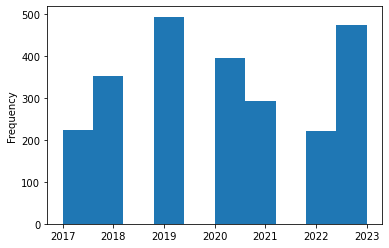

In [98]:
factors['transfer_year'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

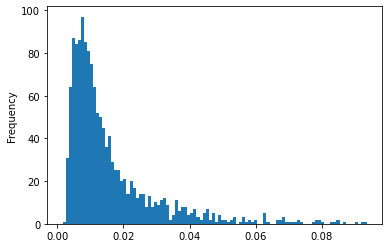

In [99]:
targets['total_mortality_perc_90'].plot.hist(bins=100)

In [100]:
#check this. if ratio is very high (e.g., 300) than PCA doesn't work well, probably, because of scaler issues
for c in factors.columns.difference(key_columns):
    ratio = factors[c].max()/factors[c].mean()
    if ratio>100: print(c, int(ratio))

C:\Users\dmitrii\AppData\Local\Temp\ipykernel_14904\2085766741.py:3: RuntimeWarning: invalid value encountered in double_scalars
  ratio = factors[c].max()/factors[c].mean()


In [101]:
# #manualy remove outlier which is 300x times higher than mean
# factors.loc[factors['density_FW_SW_ratio']>factors['density_FW_SW_ratio'].quantile(.9999),'density_FW_SW_ratio'] = np.nan

In [102]:
#we drop bano column as it wrongly defined as 0 where should be nan. Also we have similar feature 'is_nacl-after_first_feeding-sum'
#we drop also wholeper features - these 2 features should be replaced with one isNacl. Now it's biased on transfer year, initially bath method was used, then bano sin pmv
factors.drop(columns=['is_baño sin pmv-after_first_feeding-sum','is_bath-whole_period-sum','is_bath-after_first_feeding-sum',
       'is_baño sin pmv-whole_period-sum'],inplace=True, errors='ignore')

In [103]:
features = factors.columns.difference(key_columns)

In [104]:
# total_count1720=factors.groupby('transfer_year')['locus_id'].count().loc[2017:2020].sum()
# ratio_zeros_nan1720=factors[features.append(pd.Index(['transfer_year']))].groupby('transfer_year').apply(lambda x:((x==0)|(x.isna())).sum()).loc[2017:2020].sum()/total_count1720
# ratio_zeros_nan1720[ratio_zeros_nan1720>.9].index

In [105]:
total_count1719=factors.groupby('transfer_year')['locus_id'].count().loc[2017:2019].sum()
ratio_zeros_nan1719=factors[features.append(pd.Index(['transfer_year']))].groupby('transfer_year').apply(lambda x:((x==0)|(x.isna())).sum()).loc[2017:2019].sum()/total_count1719#['is_baño sin pmv-after_first_feeding-sum']
features_with_high_nan_zeros1719 = list(ratio_zeros_nan1719[ratio_zeros_nan1719>.9].index)

In [106]:
#save_path = result_data_path / 'factor_ranking'
#save_path.mkdir(exist_ok=True)
#pd.Series(features_with_high_nan_zeros1719).to_csv(f'{save_path}/features_with_high_nan_zeros1719.csv', index=False)

<AxesSubplot:ylabel='Frequency'>

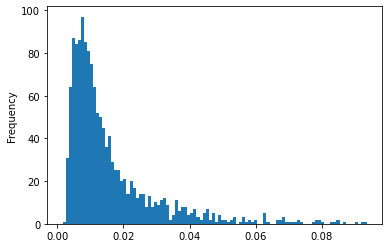

In [107]:
mortality['total_mortality_perc_90'].plot.hist(bins=100)

In [108]:
most_relevant_features = [
    'temperature_fw_sw_diff',
    'atpasa_derivative', 
    'number_of_weeks_with_summer_vac_transfer',
    'temperature_cleared-before_first_feeding-mean', 
    'is_luf_weighted', 
    'fw_cycle_length_first_mvmt_shipout',
    'temperature_cleared-before_first_feeding-degree_days',
    'is_nacl-whole_period-sum',
    'is_nacl-after_first_feeding-sum',
    'mortality_rate-after_first_feeding-sum_Desadaptado'
]

In [109]:
factors = factors[key_columns + most_relevant_features]

In [110]:
#factors = factors[factors['transfer_year']==2023]

In [111]:
# factors_targets = factors.merge(
#     mortality[key_columns + ['total_mortality_perc_90']],
#     on=key_columns,
#     how='inner'
# )
# #).merge(
# #    targets[key_columns + ['nSFR']]
# #).merge(
# #     tgc[key_columns + ['TGC_SW']],
# #     on=key_columns,
# #     how='inner'
# # )

# factors_targets.drop(key_columns, inplace=True, axis=1)

# factors_targets.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)
# #factors_targets.rename(columns={'TGC_SW': 'tgc'}, inplace=True)
# #factors_targets.rename(columns={'nSFR': 'nsfr'}, inplace=True)

# factors_targets['log_mortality'] = np.log(factors_targets['mortality'])

In [112]:
#save_path = result_data_path / 'main'
#save_path.mkdir(exist_ok=True)
factors.to_csv(f'../data/factors_main.csv', index=False,encoding='windows-1252')
# factors

## Factor ranking


### 1. Correlation analysis

We perform correlation analysis on a raw (non-filled wih median, non dropped nan rows) dataframe since we care about correlations of all existing samples for all features.
Normalizing also does not affect correlation, so no scaling yet.

In [189]:
#coef for outlier removal
coef_std = 5

In [190]:
# factors_targets_no_outliers = factors_targets.copy()
factors_targets_no_outliers = factors_targets

for feature in features:
    Q1 = factors_targets_no_outliers[feature].quantile(0.25)
    Q3 = factors_targets_no_outliers[feature].quantile(0.75)
    IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
    lower_bound = factors_targets_no_outliers[feature].mean()-coef_std*factors_targets_no_outliers[feature].std()
    upper_bound = factors_targets_no_outliers[feature].mean()+coef_std*factors_targets_no_outliers[feature].std()
    
    outliers = (factors_targets_no_outliers[feature] < lower_bound) | (factors_targets_no_outliers[feature] > upper_bound)
    factors_targets_no_outliers.loc[outliers, feature] = factors_targets_no_outliers[feature].clip(lower=lower_bound, upper=upper_bound)

In [191]:
# factors_no_outliers = factors.copy()
factors_no_outliers = factors

for feature in features:
#     Q1 = factors_targets_no_outliers[feature].quantile(0.25)
#     Q3 = factors_targets_no_outliers[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
    lower_bound = factors_no_outliers[feature].mean()-coef_std*factors_no_outliers[feature].std()
    upper_bound = factors_no_outliers[feature].mean()+coef_std*factors_no_outliers[feature].std()
    
    outliers = (factors_no_outliers[feature] < lower_bound) | (factors_no_outliers[feature] > upper_bound)
    factors_no_outliers.loc[outliers, feature] = factors_no_outliers[feature].clip(lower=lower_bound, upper=upper_bound)

In [1937]:
def count_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = column.mean()-coef_std*column.std()
    upper_bound = column.mean()+coef_std*column.std()
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
    outliers = (column < lower_bound) | (column > upper_bound)
    return outliers.sum()

# Apply the function to each column (feature) and print the results
outlier_counts = factors_targets.apply(count_outliers)
print("Number of outliers per feature:")
print(outlier_counts)

Number of outliers per feature:
is_ipn-whole_period-sum                                    0
is_nacl-after_first_feeding-sum                            0
is_nacl-whole_period-sum                                   0
is_saprosafe aw-whole_period-sum                           0
is_cloramina t-whole_period-sum                            0
is_bronopol-whole_period-sum                               0
sfr-4_weeks_before_transfer-relative_lower_min-0.01        0
ups_length                                                 0
fw_cycle_length_first_mvmt_shipout                         0
fw_cycle_length_first_feeding_shipout                      0
fw_cycle_length_first_mvmt_first_feeding                   0
to_avg_weight                                              0
density_FW                                                 0
days_btw_to_from                                           0
weight_BI                                                  0
mortality_rate-6_weeks_before_transfer-sum           

In [1938]:
# target_correlations = factors_targets[features].corrwith(factors_targets[target])
# target_correlations = target_correlations.reindex(
#     target_correlations.abs().sort_values(ascending=False).index)
target_correlations = factors_targets_no_outliers[features].corrwith(factors_targets_no_outliers[target])
target_correlations = target_correlations.reindex(
    target_correlations.abs().sort_values(ascending=False).index)

In [1939]:
# ty_2021_index = factors[factors.transfer_year==2021].index
# ty_2022_index = factors[factors.transfer_year==2022].index
# target_correlations = factors_targets.loc[ty_2021_index][features].corrwith(factors_targets.loc[ty_2021_index][target])
# target_correlations = target_correlations.reindex(
#     target_correlations.abs().sort_values(ascending=False).index)

In [1940]:
target

'log_mortality'

In [1941]:
target_correlations

av.light_hours_per_day_vac                                0.401972
number_of_weeks_with_summer_vac_transfer_normalized       0.394876
number_of_weeks_with_summer_vac_transfer                  0.301980
mortality_rate-after_first_feeding-sum_Desadaptado       -0.263366
temperature_fw_sw_diff                                    0.247707
mortality_rate-6_weeks_before_transfer-sum                0.243626
temperature_cleared-before_first_feeding-mean             0.225271
eight_last_weeks-sfr                                     -0.224797
ph-8_weeks_before_transfer-relative_higher_max-7.3       -0.203684
drop_count_coef=0.5                                       0.198278
sfr-4_weeks_before_transfer-relative_lower_min-0.01       0.197233
temperature_cleared-transfer_feeding-degree_days          0.196035
is_cloramina t-whole_period-sum                          -0.183267
ammonium-4_weeks_before_transfer-cv                       0.176755
is_nacl-after_first_feeding-sum                          -0.17

In [1942]:
# # fig = px.bar(target_correlations,
# #              color=target_correlations,
# #              color_continuous_scale=['red','blue'],
# #              title=f'Features Correlation with {target}')
# # fig.layout.xaxis.tickangle = 300
# # fig.layout.xaxis.dtick = 0
# # fig.layout.xaxis.title = 'feature'
# # fig.layout.yaxis.title = 'correlation'
# # fig.show()
# arr_for_chart = pd.DataFrame(target_correlations).reset_index()
# arr_for_chart.columns = ['feature','correlation']
# # Create a custom color palette
# colors = ['teal' if item < 0 else 'purple' for item in target_correlations]

# # Create a bar plot
# plt.figure(figsize=(10, 6))
# sns.barplot(data=arr_for_chart, x='feature', y='correlation', palette=colors)

# # Customize the plot
# plt.title(f'Features Correlation with {target}')
# plt.xlabel('Feature')
# plt.ylabel('Correlation')

# # Rotate x-axis labels
# plt.xticks(rotation=60, ha='right')
# plt.tight_layout()

# save_path = img_path / 'correlation'
# save_path.mkdir(exist_ok=True)
# # fig.write_image(f'{save_path}/correlation_{target}.png')
# # plt.savefig(f'{save_path}/correlation_{target}.png')

In [1943]:
top_20_corr_factors = target_correlations.index[:20]
display(top_20_corr_factors)

Index(['av.light_hours_per_day_vac',
       'number_of_weeks_with_summer_vac_transfer_normalized',
       'number_of_weeks_with_summer_vac_transfer',
       'mortality_rate-after_first_feeding-sum_Desadaptado',
       'temperature_fw_sw_diff', 'mortality_rate-6_weeks_before_transfer-sum',
       'temperature_cleared-before_first_feeding-mean', 'eight_last_weeks-sfr',
       'ph-8_weeks_before_transfer-relative_higher_max-7.3',
       'drop_count_coef=0.5',
       'sfr-4_weeks_before_transfer-relative_lower_min-0.01',
       'temperature_cleared-transfer_feeding-degree_days',
       'is_cloramina t-whole_period-sum',
       'ammonium-4_weeks_before_transfer-cv',
       'is_nacl-after_first_feeding-sum',
       'temperature_cleared-before_first_feeding-degree_days',
       'ammonium-4_weeks_before_transfer-std', 'eight_last_weeks-fcr',
       'temperature_cleared-transfer_feeding-median',
       'ammonium-8_weeks_before_transfer-max'],
      dtype='object')

In [1944]:
corr = factors_targets[features].corr()

# plt.figure(figsize=(20, 15))
# ax = plt.subplot(1,1,1)
# fig = sns.heatmap(corr, ax=ax, cmap='coolwarm')
# plt.tight_layout()

# save_path = img_path / 'correlation'
# save_path.mkdir(exist_ok=True)
# # fig.get_figure().savefig(f'{save_path}/correlation_features.jpg')

#### Setting up correlation threshold to see highly-correlated features

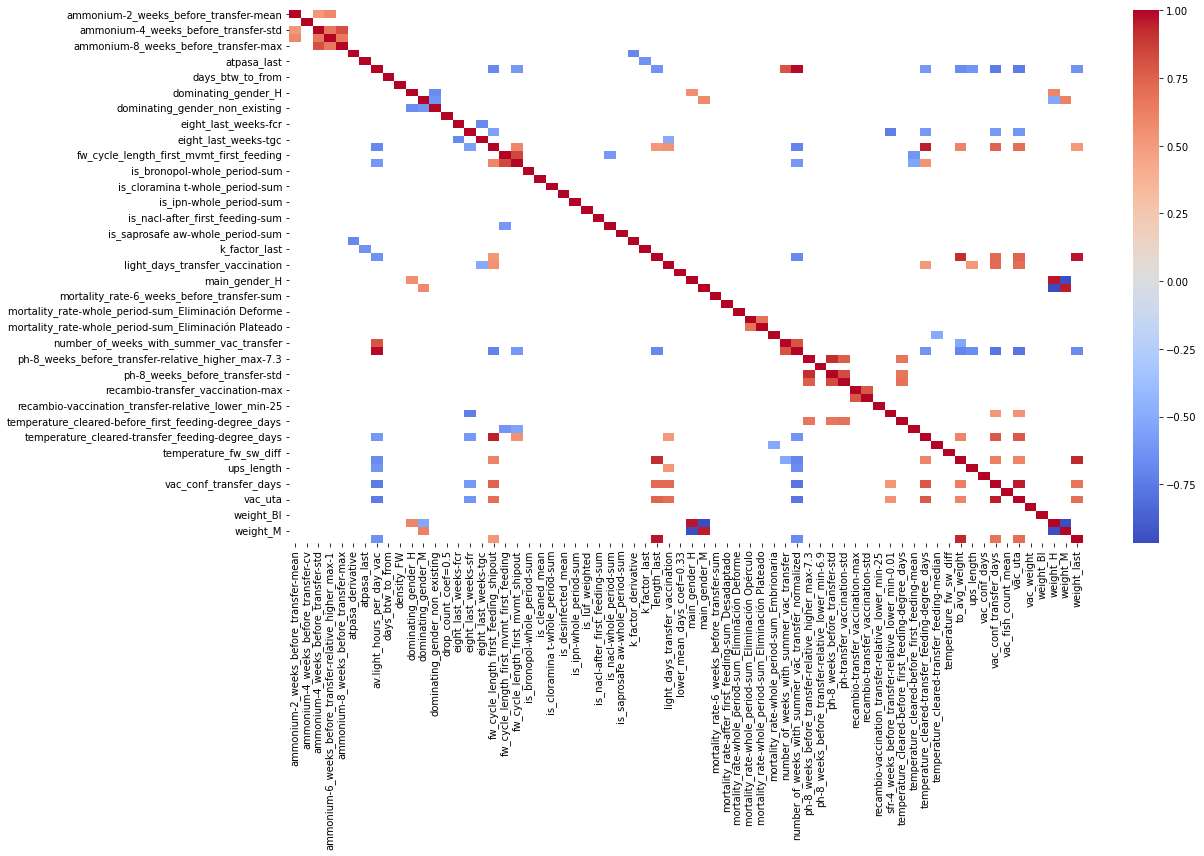

In [1945]:
CORRELATION_THRESHOLD = 0.5
high_corr = corr[abs(corr) >= CORRELATION_THRESHOLD]

plt.figure(figsize=(18,12))
ax = plt.subplot(1,1,1)
fig = sns.heatmap(high_corr, ax=ax, cmap='coolwarm')

plt.tight_layout()

save_path = img_path / 'correlation'
save_path.mkdir(exist_ok=True)
fig.get_figure().savefig(f'{save_path}/high_correlation_features.jpg')

high_corr = high_corr[high_corr != 1]
correlated_pairs = high_corr[high_corr.notnull()].stack().index
correlated_pairs = correlated_pairs.to_frame().reset_index(drop=True)

save_path = result_data_path / 'correlation'
save_path.mkdir(exist_ok=True)
# correlated_pairs.to_csv(f'{save_path}/highly_correlated_features.csv', index=False)

### 2. PCA

In [1946]:
mask = factors['locus_id'].isin(nan_key['locus_id']) \
        & factors['fish_group_id'].isin(nan_key['fish_group_id']) \
        & factors['transfer_year'].isin(nan_key['transfer_year'])
factors = factors[~mask]  # removing common nans
# factors.isna().sum()

In [1947]:
factors.columns

Index(['locus_id', 'fish_group_id', 'transfer_year', 'is_ipn-whole_period-sum',
       'is_nacl-after_first_feeding-sum', 'is_nacl-whole_period-sum',
       'is_saprosafe aw-whole_period-sum', 'is_cloramina t-whole_period-sum',
       'is_bronopol-whole_period-sum',
       'sfr-4_weeks_before_transfer-relative_lower_min-0.01', 'ups_length',
       'fw_cycle_length_first_mvmt_shipout',
       'fw_cycle_length_first_feeding_shipout',
       'fw_cycle_length_first_mvmt_first_feeding', 'to_avg_weight',
       'density_FW', 'days_btw_to_from', 'weight_BI',
       'mortality_rate-6_weeks_before_transfer-sum',
       'mortality_rate-after_first_feeding-sum_Desadaptado',
       'mortality_rate-whole_period-sum_Eliminación Deforme',
       'mortality_rate-whole_period-sum_Eliminación Plateado',
       'mortality_rate-whole_period-sum_Eliminación Opérculo',
       'mortality_rate-whole_period-sum_Embrionaria', 'is_luf_weighted',
       'temperature_fw_sw_diff', 'temperature_cleared-transfer_feed

Splitting features based on how well they are represented (i.e. nan count). Then apply PCA on:
1. all samples on well represented features only
2. samples with both well and poorly represented features without nans

and get 2 sets of important features

In [2033]:
save_path = result_data_path / 'main'
save_path.mkdir(exist_ok=True)
factors.to_csv(f'{save_path}/factors_main_for_clustering.csv', index=False,encoding='windows-1252')
# factors

In [1949]:
# Setting up the threshold to split features by ratio of missing data

NAN_THRESHOLD = 1 / 3

represented_features = factors[features].columns[
    factors[features].isna().sum() <= factors.shape[0] * NAN_THRESHOLD
]

#NEW
represented_features=represented_features.difference(features_with_high_nan_zeros1719)

represented_factors = factors[key_columns + represented_features.tolist()]

represented_factors = represented_factors.fillna(represented_factors.median()) # Filling nans with median

# plt.figure()
# sns.countplot(
#     data=represented_factors,
#     x='transfer_year'
# )
# plt.title('Transfer years countplot for well represented values')
# plt.show()

# plt.figure()
# plt.title('Transfer years countplot including poorly represented values')
unrepresented_features = list(factors.columns.difference(key_columns+represented_features.to_list()))
# unrepresented_factors = factors.dropna()  # Dropping all nans
# unrepresented_factors = factors[factors.transfer_year>=2020][key_columns+unrepresented_features]
unrepresented_factors = factors[factors.transfer_year>=2020][key_columns+list(features)]
unrepresented_factors = unrepresented_factors.fillna(unrepresented_factors.median()) # Filling nans with median

# sns.countplot(
#     data=unrepresented_factors,
#     x='transfer_year'
# )
# plt.show()

In [1950]:
# np.intersect1d(features_with_high_nan_zeros1719,represented_factors.columns)

In [1951]:
#filter out features with a lot of zeros (the same nature as NaN)
represented_features=list(represented_factors.columns.difference(features_with_high_nan_zeros1719).difference(key_columns))
# represented_features=represented_features.difference(['density_FW_SW_ratio'])
represented_factors=represented_factors[key_columns+represented_features]

In [1952]:
# factors.groupby('transfer_year')['density_FW_SW_ratio'].mean()

In [1953]:
# factors[factors['density_FW_SW_ratio']>500]

In [1954]:
# factors_targets2=factors.merge(
#     mortality[key_columns + ['total_mortality_perc_90']],
#     on=key_columns,
#     how='inner'
# )
# factors_targets2.groupby('transfer_year')['total_mortality_perc_90'].mean()

In [1955]:
# scaler = RobustScaler()
scaler = StandardScaler()
represented_factors_scaled = represented_factors.copy()
represented_factors_scaled[represented_features] = scaler.fit_transform(
    represented_factors_scaled[represented_features]
)


# scaler = RobustScaler()
scaler = StandardScaler()
unrepresented_factors_scaled = unrepresented_factors.copy()
unrepresented_factors_scaled[features] = scaler.fit_transform(
    unrepresented_factors[features]
)

save_path = result_data_path / 'split'
save_path.mkdir(exist_ok=True)
# represented_factors_scaled.to_csv(f'{save_path}/represented_factors.csv', index=False)
# unrepresented_factors_scaled.to_csv(f'{save_path}/unrepresented_factors.csv', index=False)

### 2.1 PCA on represented features

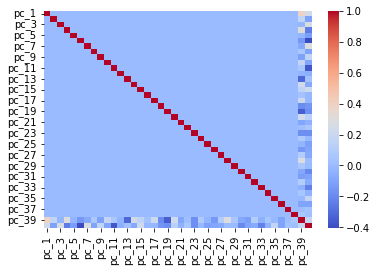

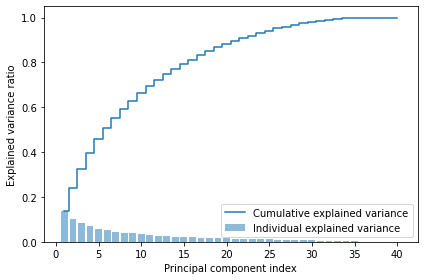

In [1956]:
n_components = len(represented_features)
pca = PCA(n_components=n_components)
pca.fit(represented_factors_scaled[represented_features])

pca_represented = pd.DataFrame(pca.transform(represented_factors_scaled[represented_features]))
pca_cols = [f'pc_{i+1}' for i in range(n_components)]
pca_represented.columns = pca_cols

plt.figure()
sns.heatmap(pca_represented.corr(), cmap='coolwarm')

plt.figure()
plt.bar(
    range(1, len(pca.explained_variance_ratio_) + 1),
    pca.explained_variance_ratio_,
    alpha=0.5,
    align='center',
    label='Individual explained variance'
)
plt.step(
    range(1, len(pca.explained_variance_ratio_) + 1),
    np.cumsum(pca.explained_variance_ratio_),
    where='mid',
    label='Cumulative explained variance'
)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [1957]:
EXPLAINED_VAR_THRESHOLD = 0.95

PCA_COMPONENTS = np.where(np.cumsum(pca.explained_variance_ratio_) > EXPLAINED_VAR_THRESHOLD)[0][0] + 1
print(PCA_COMPONENTS)
pca = PCA(n_components=PCA_COMPONENTS)
pca.fit(represented_factors_scaled[represented_features])

pca_represented = pd.DataFrame(pca.transform(represented_factors_scaled[represented_features]))
pca_cols = [f'pc_{i+1}' for i in range(PCA_COMPONENTS)]

pca_represented.columns = pca_cols

26


In [1961]:
PCA_THRESHOLD = 0.25

pca_components_represented = pd.DataFrame(pca.components_, columns=list(represented_features))
pca_components_represented_=pca_components_represented.copy()

pca_components_represented = pca_components_represented[pca_components_represented > PCA_THRESHOLD]\
.dropna(how='all', axis=1)
assert pca_components_represented.notna().any(axis=1).all(), 'Not all components explained, lower threshold'
pca_features_represented = pca_components_represented.columns

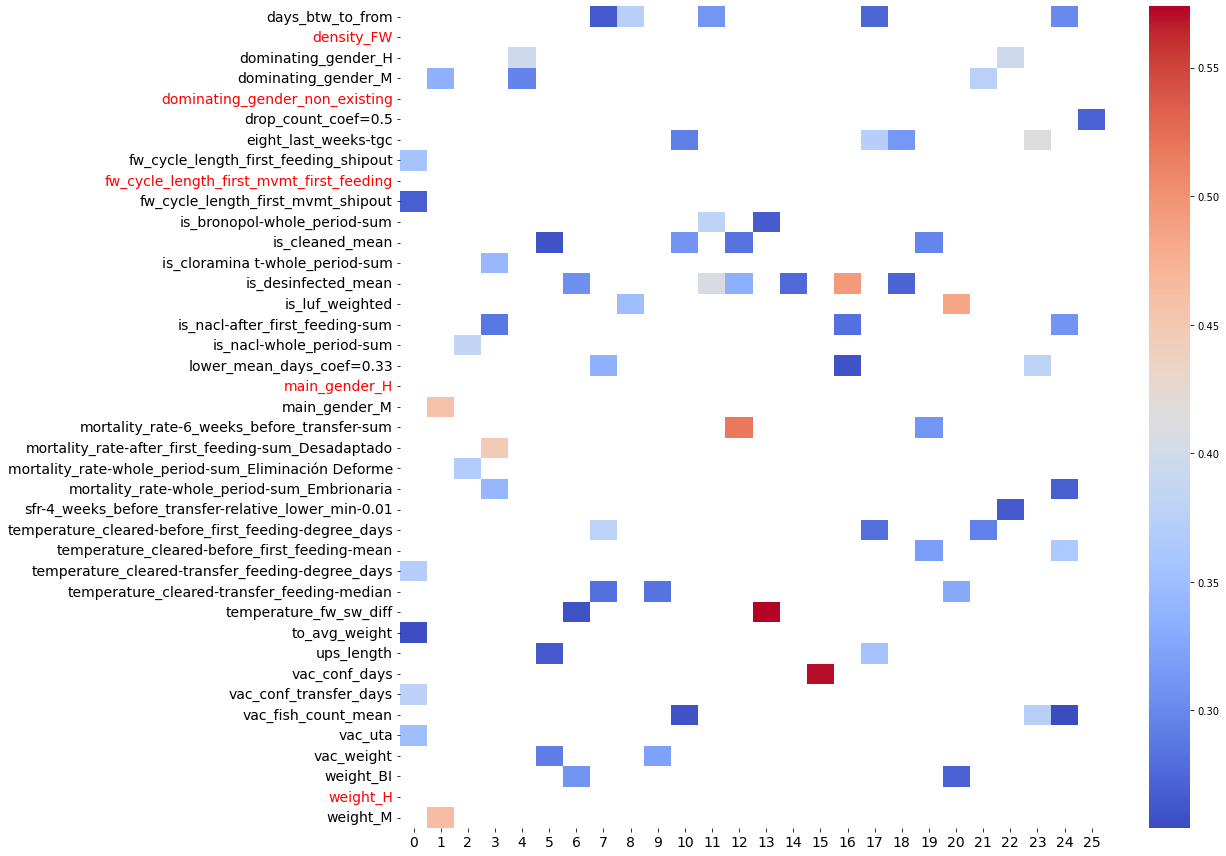

In [1962]:
#Features highlighted with red color doesn't explain any PCA component and should be treated as not important
mask = pca_components_represented_[pca_components_represented_ > PCA_THRESHOLD].notna().any(axis=0) == False

# Create a heatmap
plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1)
fig = sns.heatmap(pca_components_represented_[pca_components_represented_ > PCA_THRESHOLD].T, ax=ax, cmap='coolwarm')

# Set the y-label colors
for label in ax.get_yticklabels():
    if mask[label.get_text()]:
        label.set_color('red')
    label.set_fontsize(14)
    
# Set the x-label colors
for label in ax.get_xticklabels():
    label.set_fontsize(14)

# plt.show()

save_path = img_path / 'pca'
save_path.mkdir(exist_ok=True)
plt.tight_layout()
# fig.get_figure().savefig(f'{save_path}/represented_factors_selection.jpg')

In [1963]:
# mask = pca_components_represented_[pca_components_represented_ > PCA_THRESHOLD].notna().any(axis=0) == False

# # Create a heatmap
# plt.figure(figsize=(18, 12))
# ax = plt.subplot(1, 1, 1)
# fig = sns.heatmap(pca_components_represented_[pca_components_represented_ > PCA_THRESHOLD].T, ax=ax, cmap='coolwarm')

# # Set the y-label colors
# for label in ax.get_yticklabels():
#     if mask[label.get_text()]:
#         label.set_color('red')
#     label.set_fontsize(14)
    
# # Set the x-label colors
# for label in ax.get_xticklabels():
#     label.set_fontsize(14)

# # plt.show()

# save_path = img_path / 'pca'
# save_path.mkdir(exist_ok=True)
# plt.tight_layout()
# # fig.get_figure().savefig(f'{save_path}/represented_factors_selection.jpg')

In [1964]:
# x = factors['vac_weight']
# y = factors['number_of_weeks_with_summer_vac_transfer']
# # y = factors['number_of_weeks_with_summer_vac_transfer_normalized']

# # Create the scatter plot
# plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
# plt.scatter(x, y, alpha=0.5)  # 'alpha' controls the transparency of points

# # Add labels and title
# plt.xlabel('vac_weight (g)')
# plt.ylabel('number_of_weeks_with_summer_vac_transfer')

# # Show the plot
# plt.grid(True)
# plt.show()

In [1965]:
# x = factors['density_FW']
# y = factors['density_FW_SW_ratio']
# # y = factors['number_of_weeks_with_summer_vac_transfer_normalized']

# # Create the scatter plot
# plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
# plt.scatter(x, y, alpha=0.5)  # 'alpha' controls the transparency of points

# # Add labels and title
# # plt.xlabel('vac_weight (g)')
# # plt.ylabel('number_of_weeks_with_summer_vac_transfer')

# # Show the plot
# plt.grid(True)
# plt.show()

In [1966]:
# factors_targets[factors_targets.density_FW_SW_ratio<factors_targets.density_FW_SW_ratio.quantile(.95)][['density_FW_SW_ratio','density_FW','density_SW','mortality','nsfr']].corr()

In [1967]:
factors_targets.columns

Index(['is_ipn-whole_period-sum', 'is_nacl-after_first_feeding-sum',
       'is_nacl-whole_period-sum', 'is_saprosafe aw-whole_period-sum',
       'is_cloramina t-whole_period-sum', 'is_bronopol-whole_period-sum',
       'sfr-4_weeks_before_transfer-relative_lower_min-0.01', 'ups_length',
       'fw_cycle_length_first_mvmt_shipout',
       'fw_cycle_length_first_feeding_shipout',
       'fw_cycle_length_first_mvmt_first_feeding', 'to_avg_weight',
       'density_FW', 'days_btw_to_from', 'weight_BI',
       'mortality_rate-6_weeks_before_transfer-sum',
       'mortality_rate-after_first_feeding-sum_Desadaptado',
       'mortality_rate-whole_period-sum_Eliminación Deforme',
       'mortality_rate-whole_period-sum_Eliminación Plateado',
       'mortality_rate-whole_period-sum_Eliminación Opérculo',
       'mortality_rate-whole_period-sum_Embrionaria', 'is_luf_weighted',
       'temperature_fw_sw_diff', 'temperature_cleared-transfer_feeding-median',
       'temperature_cleared-transfer_fee

In [1968]:
# factors[factors['density_FW_SW_ratio']>200]

In [1969]:
display(pca_features_represented, pca_features_represented.shape[0])

Index(['days_btw_to_from', 'dominating_gender_H', 'dominating_gender_M',
       'drop_count_coef=0.5', 'eight_last_weeks-tgc',
       'fw_cycle_length_first_feeding_shipout',
       'fw_cycle_length_first_mvmt_shipout', 'is_bronopol-whole_period-sum',
       'is_cleaned_mean', 'is_cloramina t-whole_period-sum',
       'is_desinfected_mean', 'is_luf_weighted',
       'is_nacl-after_first_feeding-sum', 'is_nacl-whole_period-sum',
       'lower_mean_days_coef=0.33', 'main_gender_M',
       'mortality_rate-6_weeks_before_transfer-sum',
       'mortality_rate-after_first_feeding-sum_Desadaptado',
       'mortality_rate-whole_period-sum_Eliminación Deforme',
       'mortality_rate-whole_period-sum_Embrionaria',
       'sfr-4_weeks_before_transfer-relative_lower_min-0.01',
       'temperature_cleared-before_first_feeding-degree_days',
       'temperature_cleared-before_first_feeding-mean',
       'temperature_cleared-transfer_feeding-degree_days',
       'temperature_cleared-transfer_feeding-

35

In [1970]:
pd.Index(represented_features).difference(pca_features_represented)

Index(['density_FW', 'dominating_gender_non_existing',
       'fw_cycle_length_first_mvmt_first_feeding', 'main_gender_H',
       'weight_H'],
      dtype='object')

In [1971]:
len(features)

68

### 2.2 PCA on all features since 2020

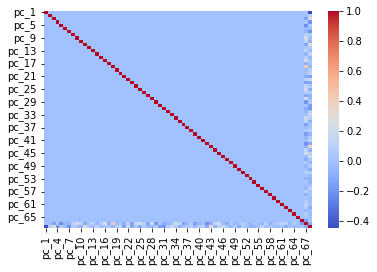

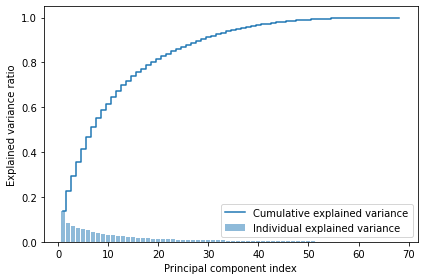

In [1972]:
n_components = len(features)
pca = PCA(n_components=n_components)
# pca = PCA(n_components='auto')
pca.fit(unrepresented_factors_scaled[features])

pca_unrepresented = pd.DataFrame(pca.transform(unrepresented_factors_scaled[features]))
pca_cols = [f'pc_{i+1}' for i in range(n_components)]
pca_unrepresented.columns = pca_cols

plt.figure()
sns.heatmap(pca_unrepresented.corr(), cmap='coolwarm')

plt.figure()
plt.bar(
    range(1, len(pca.explained_variance_ratio_) + 1),
    pca.explained_variance_ratio_,
    alpha=0.5,
    align='center',
    label='Individual explained variance'
)
plt.step(
    range(1, len(pca.explained_variance_ratio_) + 1),
    np.cumsum(pca.explained_variance_ratio_),
    where='mid',
    label='Cumulative explained variance'
)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [1973]:
EXPLAINED_VAR_THRESHOLD = 0.95

PCA_COMPONENTS = np.where(np.cumsum(pca.explained_variance_ratio_) > EXPLAINED_VAR_THRESHOLD)[0][0] + 1
print(PCA_COMPONENTS)
pca = PCA(n_components=PCA_COMPONENTS)
pca.fit(unrepresented_factors_scaled[features])

pca_unrepresented = pd.DataFrame(pca.transform(unrepresented_factors_scaled[features]))
pca_cols = [f'pc_{i+1}' for i in range(PCA_COMPONENTS)]

pca_unrepresented.columns = pca_cols

37


In [1974]:
PCA_THRESHOLD = 0.16

pca_components_unrepresented = pd.DataFrame(pca.components_, columns=list(features))
pca_components_unrepresented_=pca_components_unrepresented.copy()

pca_components_unrepresented = pca_components_unrepresented[pca_components_unrepresented > PCA_THRESHOLD]\
.dropna(how='all', axis=1)
assert pca_components_unrepresented.notna().any(axis=1).all(), 'Not all components explained, lower threshold'
pca_features_unrepresented = pca_components_unrepresented.columns

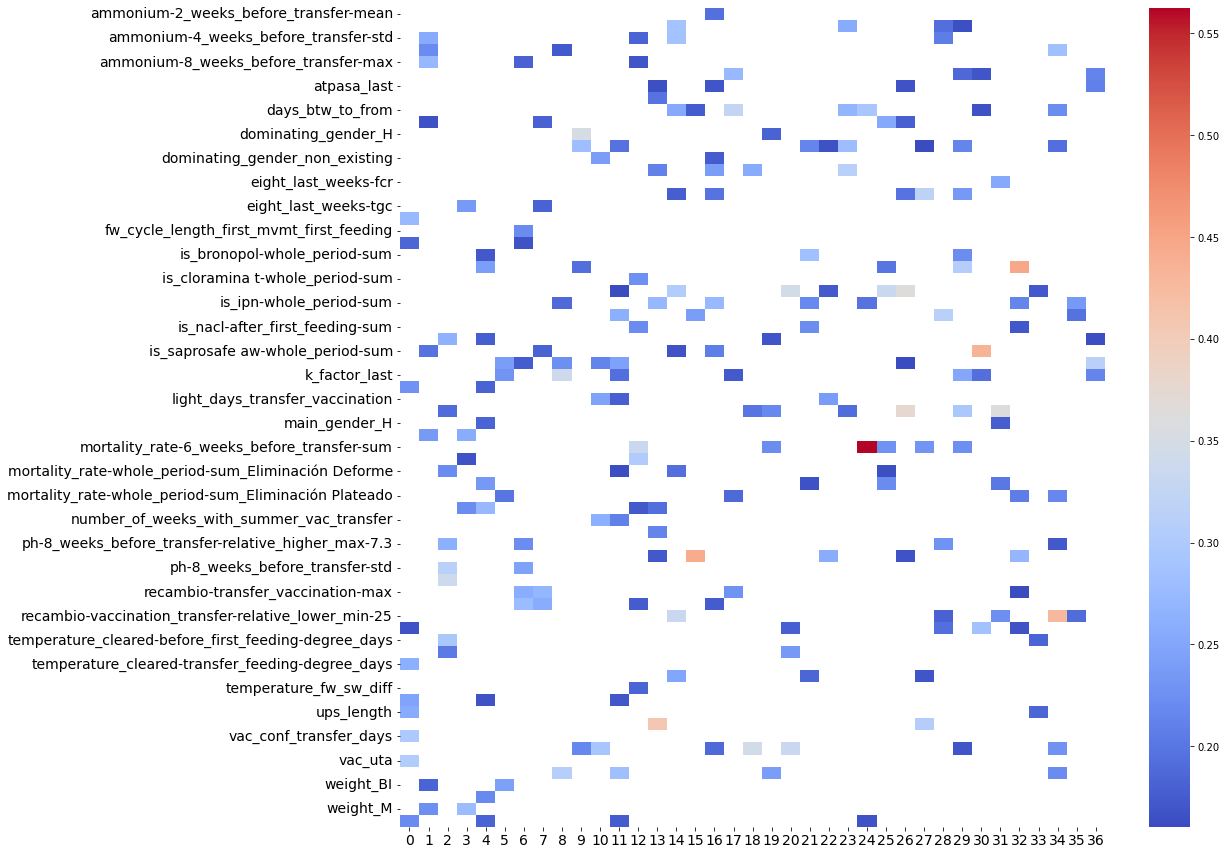

In [1975]:
#Features highlighted with red color doesn't explain any PCA component and should be treated as not important
mask = pca_components_unrepresented_[pca_components_unrepresented_ > PCA_THRESHOLD].notna().any(axis=0) == False

# Create a heatmap
plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1)
fig = sns.heatmap(pca_components_unrepresented_[pca_components_unrepresented_ > PCA_THRESHOLD].T, ax=ax, cmap='coolwarm')

# Set the y-label colors
for label in ax.get_yticklabels():
    if mask[label.get_text()]:
        label.set_color('red')
    label.set_fontsize(14)
    
# Set the x-label colors
for label in ax.get_xticklabels():
    label.set_fontsize(14)

# plt.show()

save_path = img_path / 'pca'
save_path.mkdir(exist_ok=True)
plt.tight_layout()
# fig.get_figure().savefig(f'{save_path}/represented_factors_selection.jpg')

In [1976]:
display(pca_features_unrepresented, pca_features_unrepresented.shape[0])

Index(['ammonium-2_weeks_before_transfer-mean',
       'ammonium-4_weeks_before_transfer-cv',
       'ammonium-4_weeks_before_transfer-std',
       'ammonium-6_weeks_before_transfer-relative_higher_max-1',
       'ammonium-8_weeks_before_transfer-max', 'atpasa_derivative',
       'atpasa_last', 'av.light_hours_per_day_vac', 'days_btw_to_from',
       'density_FW', 'dominating_gender_H', 'dominating_gender_M',
       'dominating_gender_non_existing', 'drop_count_coef=0.5',
       'eight_last_weeks-fcr', 'eight_last_weeks-sfr', 'eight_last_weeks-tgc',
       'fw_cycle_length_first_feeding_shipout',
       'fw_cycle_length_first_mvmt_first_feeding',
       'fw_cycle_length_first_mvmt_shipout', 'is_bronopol-whole_period-sum',
       'is_cleaned_mean', 'is_cloramina t-whole_period-sum',
       'is_desinfected_mean', 'is_ipn-whole_period-sum', 'is_luf_weighted',
       'is_nacl-after_first_feeding-sum', 'is_nacl-whole_period-sum',
       'is_saprosafe aw-whole_period-sum', 'k_factor_derivati

68

In [1977]:
len(pca_features_represented),len(pca_features_unrepresented),len(features)

(35, 68, 68)

In [1978]:
pca_features_represented.difference(pca_features_unrepresented)

Index([], dtype='object')

In [1979]:
pca_features_represented

Index(['days_btw_to_from', 'dominating_gender_H', 'dominating_gender_M',
       'drop_count_coef=0.5', 'eight_last_weeks-tgc',
       'fw_cycle_length_first_feeding_shipout',
       'fw_cycle_length_first_mvmt_shipout', 'is_bronopol-whole_period-sum',
       'is_cleaned_mean', 'is_cloramina t-whole_period-sum',
       'is_desinfected_mean', 'is_luf_weighted',
       'is_nacl-after_first_feeding-sum', 'is_nacl-whole_period-sum',
       'lower_mean_days_coef=0.33', 'main_gender_M',
       'mortality_rate-6_weeks_before_transfer-sum',
       'mortality_rate-after_first_feeding-sum_Desadaptado',
       'mortality_rate-whole_period-sum_Eliminación Deforme',
       'mortality_rate-whole_period-sum_Embrionaria',
       'sfr-4_weeks_before_transfer-relative_lower_min-0.01',
       'temperature_cleared-before_first_feeding-degree_days',
       'temperature_cleared-before_first_feeding-mean',
       'temperature_cleared-transfer_feeding-degree_days',
       'temperature_cleared-transfer_feeding-

In [1980]:
pca_features_unrepresented

Index(['ammonium-2_weeks_before_transfer-mean',
       'ammonium-4_weeks_before_transfer-cv',
       'ammonium-4_weeks_before_transfer-std',
       'ammonium-6_weeks_before_transfer-relative_higher_max-1',
       'ammonium-8_weeks_before_transfer-max', 'atpasa_derivative',
       'atpasa_last', 'av.light_hours_per_day_vac', 'days_btw_to_from',
       'density_FW', 'dominating_gender_H', 'dominating_gender_M',
       'dominating_gender_non_existing', 'drop_count_coef=0.5',
       'eight_last_weeks-fcr', 'eight_last_weeks-sfr', 'eight_last_weeks-tgc',
       'fw_cycle_length_first_feeding_shipout',
       'fw_cycle_length_first_mvmt_first_feeding',
       'fw_cycle_length_first_mvmt_shipout', 'is_bronopol-whole_period-sum',
       'is_cleaned_mean', 'is_cloramina t-whole_period-sum',
       'is_desinfected_mean', 'is_ipn-whole_period-sum', 'is_luf_weighted',
       'is_nacl-after_first_feeding-sum', 'is_nacl-whole_period-sum',
       'is_saprosafe aw-whole_period-sum', 'k_factor_derivati

## 3. XGBoost

In [1981]:
represented_features

['days_btw_to_from',
 'density_FW',
 'dominating_gender_H',
 'dominating_gender_M',
 'dominating_gender_non_existing',
 'drop_count_coef=0.5',
 'eight_last_weeks-tgc',
 'fw_cycle_length_first_feeding_shipout',
 'fw_cycle_length_first_mvmt_first_feeding',
 'fw_cycle_length_first_mvmt_shipout',
 'is_bronopol-whole_period-sum',
 'is_cleaned_mean',
 'is_cloramina t-whole_period-sum',
 'is_desinfected_mean',
 'is_luf_weighted',
 'is_nacl-after_first_feeding-sum',
 'is_nacl-whole_period-sum',
 'lower_mean_days_coef=0.33',
 'main_gender_H',
 'main_gender_M',
 'mortality_rate-6_weeks_before_transfer-sum',
 'mortality_rate-after_first_feeding-sum_Desadaptado',
 'mortality_rate-whole_period-sum_Eliminación Deforme',
 'mortality_rate-whole_period-sum_Embrionaria',
 'sfr-4_weeks_before_transfer-relative_lower_min-0.01',
 'temperature_cleared-before_first_feeding-degree_days',
 'temperature_cleared-before_first_feeding-mean',
 'temperature_cleared-transfer_feeding-degree_days',
 'temperature_cleare

In [1982]:
# xgboost_features = represented_features+['number_of_weeks_with_summer_vac_transfer','eight_last_weeks-fcr']
xgboost_features = represented_features+['number_of_weeks_with_summer_vac_transfer']

# xgboost_features = represented_features

# factors_targets = factors.merge(
factors_targets = represented_factors.merge(
    mortality[key_columns + ['total_mortality_perc_90']],
    on=key_columns,
    how='inner'
).merge(
    tgc[key_columns + ['TGC_SW']],
    on=key_columns,
    how='inner'
).merge(
    targets[key_columns + ['nSFR']]
).merge(
    unrepresented_factors[key_columns+['number_of_weeks_with_summer_vac_transfer','eight_last_weeks-fcr']])

factors_targets.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)
factors_targets.rename(columns={'TGC_SW': 'tgc'}, inplace=True)
factors_targets.rename(columns={'nSFR': 'nsfr'}, inplace=True)
factors_targets['log_mortality'] = np.log(factors_targets['mortality'])

#should we use standard scaler here?
scaler = RobustScaler()
factors_targets_scaled = factors_targets.copy()
factors_targets_scaled[xgboost_features] = scaler.fit_transform(
    factors_targets_scaled[xgboost_features]
)

In [1983]:
# target = 'mortality'
target = 'log_mortality'
# target = 'nsfr'

train_data = factors_targets_scaled[factors_targets_scaled['transfer_year'] != 2023]
test_data = factors_targets_scaled[factors_targets_scaled['transfer_year'] == 2023]

# save_path = result_data_path / 'split'
# save_path.mkdir(exist_ok=True)
# train_data.to_csv(f'{save_path}/train_data.csv', index=False)
# test_data.to_csv(f'{save_path}/test_data.csv', index=False)

# X_test, y_test = test_data[represented_features], test_data[target]
X_test, y_test = test_data[xgboost_features], test_data[target]


X_train, X_val, y_train, y_val = train_test_split(
        train_data[xgboost_features],
        train_data[target],
        test_size=0.2,
        random_state=1)

In [1984]:
xgb_regressor = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [5],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb_regressor,
                        parameters,
                        cv=2,
                        n_jobs=5,
                        scoring='neg_mean_absolute_percentage_error',
                        verbose=True)
xgb_grid.fit(X_train.to_numpy(), y_train.to_numpy())

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

xgb_best = xgb.XGBRegressor(**xgb_grid.best_params_)

xgb_best.fit(X_train, y_train)
y_pred = xgb_best.predict(X_val.to_numpy())

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[16:25:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


-0.11272009781748413
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
[16:25:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated 

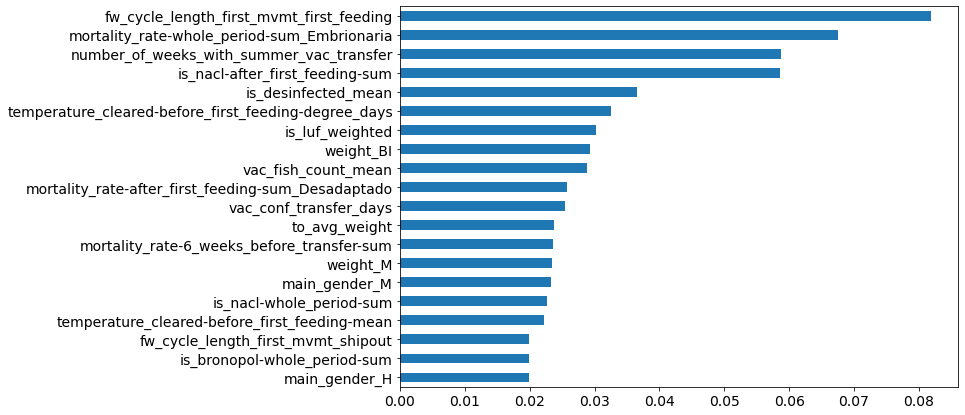

In [1985]:
importance_high_cov = xgb_best.feature_importances_
top_20_xgb_factors_high_cov = pd.Series(
    importance_high_cov, index=xgboost_features).nlargest(20)
plt.figure(figsize=(10,7))
fig = top_20_xgb_factors_high_cov.sort_values(ascending=True).plot(kind='barh')
fig.tick_params(axis='both', labelsize=14)
save_path = img_path / 'importance'
save_path.mkdir(exist_ok=True)
# fig.get_figure().savefig(f'{save_path}/xgb_top_20_factors_UPD.jpg')

In [1986]:
xgb_factors_target_corr_high_cov = factors_targets_scaled[top_20_xgb_factors_high_cov.index]\
.corrwith(factors_targets_scaled[target])

save_path = result_data_path / 'correlation'
save_path.mkdir(exist_ok=True)
# xgb_factors_target_corr.to_csv(f'{save_path}/xgb_top_20_factors_{target}_corr.csv')

display('r2:', r2_score(y_val, y_pred))

display('MAPE:', mean_absolute_percentage_error(y_val, y_pred))

display('MSE:', mean_squared_error(y_val, y_pred))

'r2:'

0.34142844160436103

'MAPE:'

0.10810460667404544

'MSE:'

0.3505926015690804

In [1987]:
# factors_targets = factors.merge(
factors_targets = unrepresented_factors.merge(
    mortality[key_columns + ['total_mortality_perc_90']],
    on=key_columns,
    how='inner'
).merge(
    tgc[key_columns + ['TGC_SW']],
    on=key_columns,
    how='inner'
).merge(
    targets[key_columns + ['nSFR']]
)

factors_targets.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)
factors_targets.rename(columns={'TGC_SW': 'tgc'}, inplace=True)
factors_targets.rename(columns={'nSFR': 'nsfr'}, inplace=True)
factors_targets['log_mortality'] = np.log(factors_targets['mortality'])

#should we use standard scaler here?
scaler = RobustScaler()
factors_targets_scaled = factors_targets.copy()
factors_targets_scaled[features] = scaler.fit_transform(
    factors_targets_scaled[features]
)

In [1988]:
# target = 'mortality'
target = 'log_mortality'

train_data = factors_targets_scaled[factors_targets_scaled['transfer_year'] != 2023]
test_data = factors_targets_scaled[factors_targets_scaled['transfer_year'] == 2023]

save_path = result_data_path / 'split'
save_path.mkdir(exist_ok=True)
train_data.to_csv(f'{save_path}/{target}_train_data.csv', index=False)
test_data.to_csv(f'{save_path}/{target}_test_data.csv', index=False)

X_test, y_test = test_data[features], test_data[target]

X_train, X_val, y_train, y_val = train_test_split(
        train_data[features],
        train_data[target],
        test_size=0.2,
        random_state=1)

In [1989]:
xgb_regressor = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [5],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb_regressor,
                        parameters,
                        cv=2,
                        n_jobs=5,
                        scoring='neg_mean_absolute_percentage_error',
                        verbose=True)
xgb_grid.fit(X_train.to_numpy(), y_train.to_numpy())

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

xgb_best = xgb.XGBRegressor(**xgb_grid.best_params_)

xgb_best.fit(X_train, y_train)
y_pred = xgb_best.predict(X_val.to_numpy())

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[16:25:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


-0.11148565014353153
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
[16:25:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated 

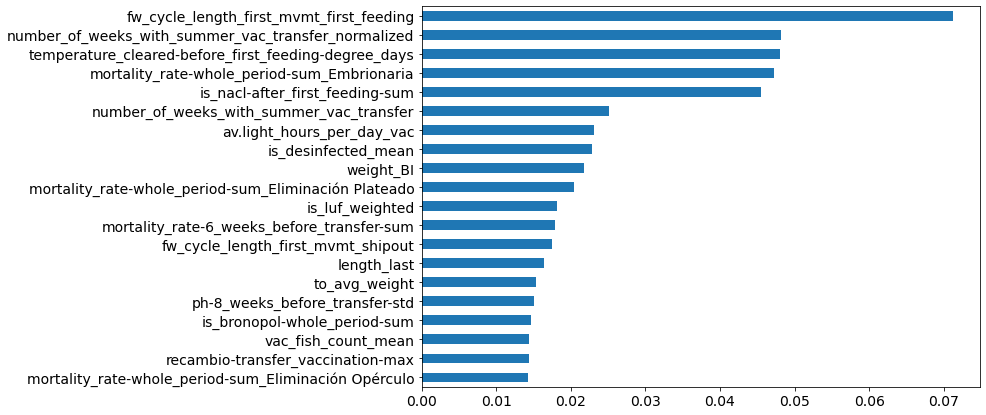

In [1990]:
importance = xgb_best.feature_importances_
top_20_xgb_factors = pd.Series(
    importance, index=features).nlargest(20)

plt.figure(figsize=(10,7))
fig = top_20_xgb_factors.sort_values(ascending=True).plot(kind='barh')
fig.tick_params(axis='both', labelsize=14)
save_path = img_path / 'importance'
save_path.mkdir(exist_ok=True)
# fig.get_figure().savefig(f'{save_path}/xgb_top_20_factors_UPD.jpg')

In [1991]:
# importance = xgb_best.feature_importances_
# top_20_xgb_factors = pd.Series(
#     importance, index=features).nlargest(20)

# fig = top_20_xgb_factors.sort_values(ascending=True).plot(kind='barh')
# save_path = img_path / 'importance'
# save_path.mkdir(exist_ok=True)
# # fig.get_figure().savefig(f'{save_path}/xgb_top_20_factors_UPD.jpg')

In [1992]:
xgb_factors_target_corr = factors_targets_scaled[top_20_xgb_factors.index]\
.corrwith(factors_targets_scaled[target])

save_path = result_data_path / 'correlation'
save_path.mkdir(exist_ok=True)
xgb_factors_target_corr.to_csv(f'{save_path}/xgb_top_20_factors_{target}_corr.csv')

display('r2:', r2_score(y_val, y_pred))

display('MAPE:', mean_absolute_percentage_error(y_val, y_pred))

display('MSE:', mean_squared_error(y_val, y_pred))

'r2:'

0.3613394921103402

'MAPE:'

0.1084983907344816

'MSE:'

0.33999289238353586

In [1993]:
# xgb_factors_target_corr = factors_targets_scaled[top_20_xgb_factors.index]\
# .corrwith(factors_targets_scaled[target])

# save_path = result_data_path / 'correlation'
# save_path.mkdir(exist_ok=True)
# xgb_factors_target_corr.to_csv(f'{save_path}/xgb_top_20_factors_{target}_corr.csv')

# display('r2:', r2_score(y_val, y_pred))

# display('MAPE:', mean_absolute_percentage_error(y_val, y_pred))

# display('MSE:', mean_squared_error(y_val, y_pred))

## 4. Finalization

In [1994]:
top_pca_factors = pca_features_represented.union(pca_features_unrepresented)

In [1995]:
len(pca_components_represented),len(pca_features_unrepresented),len(top_pca_factors),len(features)

(26, 68, 68, 68)

In [1996]:
top_20_xgb_factors

fw_cycle_length_first_mvmt_first_feeding                0.071231
number_of_weeks_with_summer_vac_transfer_normalized     0.048207
temperature_cleared-before_first_feeding-degree_days    0.048051
mortality_rate-whole_period-sum_Embrionaria             0.047280
is_nacl-after_first_feeding-sum                         0.045453
number_of_weeks_with_summer_vac_transfer                0.025080
av.light_hours_per_day_vac                              0.023157
is_desinfected_mean                                     0.022790
weight_BI                                               0.021707
mortality_rate-whole_period-sum_Eliminación Plateado    0.020384
is_luf_weighted                                         0.018182
mortality_rate-6_weeks_before_transfer-sum              0.017818
fw_cycle_length_first_mvmt_shipout                      0.017472
length_last                                             0.016355
to_avg_weight                                           0.015336
ph-8_weeks_before_transfe

In [1997]:
# top_20_xgb_factors

In [1998]:
top_20_corr_factors

Index(['av.light_hours_per_day_vac',
       'number_of_weeks_with_summer_vac_transfer_normalized',
       'number_of_weeks_with_summer_vac_transfer',
       'mortality_rate-after_first_feeding-sum_Desadaptado',
       'temperature_fw_sw_diff', 'mortality_rate-6_weeks_before_transfer-sum',
       'temperature_cleared-before_first_feeding-mean', 'eight_last_weeks-sfr',
       'ph-8_weeks_before_transfer-relative_higher_max-7.3',
       'drop_count_coef=0.5',
       'sfr-4_weeks_before_transfer-relative_lower_min-0.01',
       'temperature_cleared-transfer_feeding-degree_days',
       'is_cloramina t-whole_period-sum',
       'ammonium-4_weeks_before_transfer-cv',
       'is_nacl-after_first_feeding-sum',
       'temperature_cleared-before_first_feeding-degree_days',
       'ammonium-4_weeks_before_transfer-std', 'eight_last_weeks-fcr',
       'temperature_cleared-transfer_feeding-median',
       'ammonium-8_weeks_before_transfer-max'],
      dtype='object')

In [1999]:
# top_20_corr_factors

In [2000]:
top_pca_factors

Index(['ammonium-2_weeks_before_transfer-mean',
       'ammonium-4_weeks_before_transfer-cv',
       'ammonium-4_weeks_before_transfer-std',
       'ammonium-6_weeks_before_transfer-relative_higher_max-1',
       'ammonium-8_weeks_before_transfer-max', 'atpasa_derivative',
       'atpasa_last', 'av.light_hours_per_day_vac', 'days_btw_to_from',
       'density_FW', 'dominating_gender_H', 'dominating_gender_M',
       'dominating_gender_non_existing', 'drop_count_coef=0.5',
       'eight_last_weeks-fcr', 'eight_last_weeks-sfr', 'eight_last_weeks-tgc',
       'fw_cycle_length_first_feeding_shipout',
       'fw_cycle_length_first_mvmt_first_feeding',
       'fw_cycle_length_first_mvmt_shipout', 'is_bronopol-whole_period-sum',
       'is_cleaned_mean', 'is_cloramina t-whole_period-sum',
       'is_desinfected_mean', 'is_ipn-whole_period-sum', 'is_luf_weighted',
       'is_nacl-after_first_feeding-sum', 'is_nacl-whole_period-sum',
       'is_saprosafe aw-whole_period-sum', 'k_factor_derivati

In [2001]:
# top_pca_factors

In [2002]:
top_20_xgb_factors.index\
.intersection(top_20_corr_factors)\
.intersection(top_pca_factors)

Index(['number_of_weeks_with_summer_vac_transfer_normalized',
       'temperature_cleared-before_first_feeding-degree_days',
       'is_nacl-after_first_feeding-sum',
       'number_of_weeks_with_summer_vac_transfer',
       'av.light_hours_per_day_vac',
       'mortality_rate-6_weeks_before_transfer-sum'],
      dtype='object')

In [2003]:
# top_20_xgb_factors.index\
# .intersection(top_20_corr_factors)\
# .intersection(top_pca_factors)

In [2004]:
# #2020 is under pressure
# factors.groupby('transfer_year')['is_cleaned_mean'].mean()

In [2005]:
# strange here
# factors[factors['is_cleaned_mean']==0]

In [2006]:
intersect_1 = top_20_corr_factors.intersection(top_20_xgb_factors_high_cov.index)
intersect_2 = top_20_corr_factors.intersection(pca_features_represented)
intersect_3 = pca_features_represented.intersection(top_20_xgb_factors_high_cov.index)
intersect_4 = top_20_corr_factors.intersection(top_20_xgb_factors.index)
final_features = intersect_1.union(intersect_2).union(intersect_3).union(intersect_4)

In [2007]:
final_features.shape

(26,)

In [2008]:
final_features

Index(['av.light_hours_per_day_vac', 'drop_count_coef=0.5',
       'fw_cycle_length_first_mvmt_shipout', 'is_bronopol-whole_period-sum',
       'is_cloramina t-whole_period-sum', 'is_desinfected_mean',
       'is_luf_weighted', 'is_nacl-after_first_feeding-sum',
       'is_nacl-whole_period-sum', 'main_gender_M',
       'mortality_rate-6_weeks_before_transfer-sum',
       'mortality_rate-after_first_feeding-sum_Desadaptado',
       'mortality_rate-whole_period-sum_Embrionaria',
       'number_of_weeks_with_summer_vac_transfer',
       'number_of_weeks_with_summer_vac_transfer_normalized',
       'sfr-4_weeks_before_transfer-relative_lower_min-0.01',
       'temperature_cleared-before_first_feeding-degree_days',
       'temperature_cleared-before_first_feeding-mean',
       'temperature_cleared-transfer_feeding-degree_days',
       'temperature_cleared-transfer_feeding-median', 'temperature_fw_sw_diff',
       'to_avg_weight', 'vac_conf_transfer_days', 'vac_fish_count_mean',
       'wei

In [2009]:
# factors[factors['is_luf_weighted']==0]

In [2010]:
correlated_pairs_dict = {}

for i in range(len(final_features)):
    for j in range(i + 1, len(final_features)):
        first_feature = final_features[i]
        second_feature = final_features[j]
        if (first_feature, second_feature) not in correlated_pairs_dict and (second_feature, first_feature) not in correlated_pairs_dict:
            for idx in correlated_pairs.index:
                if correlated_pairs.iloc[idx][0] == first_feature and correlated_pairs.iloc[idx][1] == second_feature:
                    correlated_pairs_dict[(first_feature, second_feature)] = high_corr.loc[first_feature,second_feature]
# Now correlated_pairs_dict contains non-symmetric pairs and their correlation values

In [2011]:
correlated_pairs_dict

{('av.light_hours_per_day_vac',
  'fw_cycle_length_first_mvmt_shipout'): -0.6029124916472287,
 ('av.light_hours_per_day_vac',
  'number_of_weeks_with_summer_vac_transfer'): 0.7933636400685794,
 ('av.light_hours_per_day_vac',
  'number_of_weeks_with_summer_vac_transfer_normalized'): 0.9849825984731282,
 ('av.light_hours_per_day_vac',
  'temperature_cleared-transfer_feeding-degree_days'): -0.6034784638845271,
 ('av.light_hours_per_day_vac', 'to_avg_weight'): -0.6683523725620123,
 ('av.light_hours_per_day_vac', 'vac_conf_transfer_days'): -0.7454496653782481,
 ('fw_cycle_length_first_mvmt_shipout',
  'number_of_weeks_with_summer_vac_transfer_normalized'): -0.6047946835441729,
 ('fw_cycle_length_first_mvmt_shipout',
  'temperature_cleared-before_first_feeding-mean'): -0.5389182435765587,
 ('fw_cycle_length_first_mvmt_shipout',
  'temperature_cleared-transfer_feeding-degree_days'): 0.5428558564728964,
 ('main_gender_M', 'weight_M'): 0.955444329617712,
 ('mortality_rate-whole_period-sum_Embri

Remove highly correlated features

In [2020]:
to_exclude = [
    'av.light_hours_per_day_vac', #because it's similar to number of weeks with summer photoperiod
#     'is_baño sin pmv-whole_period-sum', #because first feeding is easier to control
#     'light_days_transfer_vaccination', #because it's wrongly calculated (winter should be 9 hours)
#     'temperature_cleared-transfer_feeding-degree_days',
    'vac_uta',
#     'ph-8_weeks_before_transfer-std' #because max feature is easier to interpret
    'number_of_weeks_with_summer_vac_transfer_normalized',
    'fw_cycle_length_first_feeding_shipout', #extreme correlation with 'temperature_cleared-transfer_feeding-degree_days'
#     'fw_cycle_length_first_mvmt_shipout',
#     'vac_conf_transfer_days',
    'density_FW_SW_ratio', #low interpretability
    'weight_BI' #sensitive to present
#     ,'fw_cycle_length_vac_shipout'
#     ,'is_luf_weighted' #we have to select one of the lufenuron feature
    ,'to_avg_weight' #correalted with 'number_of_weeks_with_summer_vac_transfer' and 'number_of_weeks_with_summer_vac_transfer'
#     ,'sfr-vaccination_transfer-relative_lower_min-0.01'
#     ,'eight_last_weeks-tgc'
    ,'vac_conf_transfer_days' #correlated with 'sfr-4_weeks_before_transfer-relative_lower_min-0.01', 'temperature_cleared-transfer_feeding-degree_days' and 'to_avg_weight'
    ,'main_gender_M'
    
]

In [2021]:
# factors[['ups_length','vac_conf_transfer_days','fw_cycle_length_vac_shipout']].describe()

In [2022]:
final_features = final_features[~final_features.isin(to_exclude)]

In [2023]:
correlated_pairs_dict = {}

for i in range(len(final_features)):
    for j in range(i + 1, len(final_features)):
        first_feature = final_features[i]
        second_feature = final_features[j]
        if (first_feature, second_feature) not in correlated_pairs_dict and (second_feature, first_feature) not in correlated_pairs_dict:
            for idx in correlated_pairs.index:
                if correlated_pairs.iloc[idx][0] == first_feature and correlated_pairs.iloc[idx][1] == second_feature:
                    correlated_pairs_dict[(first_feature, second_feature)] = high_corr.loc[first_feature,second_feature]
correlated_pairs_dict
# Now correlated_pairs_dict contains non-symmetric pairs and their correlation values

{('fw_cycle_length_first_mvmt_shipout',
  'temperature_cleared-before_first_feeding-mean'): -0.5389182435765587,
 ('fw_cycle_length_first_mvmt_shipout',
  'temperature_cleared-transfer_feeding-degree_days'): 0.5428558564728964,
 ('mortality_rate-whole_period-sum_Embrionaria',
  'temperature_cleared-transfer_feeding-median'): -0.5108335174796833}

In [2024]:
# corr.loc['ph-8_weeks_before_transfer-max','ph-8_weeks_before_transfer-relative_higher_max-7.3']

In [2025]:
print(len(final_features))
final_features

20


Index(['drop_count_coef=0.5', 'fw_cycle_length_first_mvmt_shipout',
       'is_bronopol-whole_period-sum', 'is_cloramina t-whole_period-sum',
       'is_desinfected_mean', 'is_luf_weighted',
       'is_nacl-after_first_feeding-sum', 'is_nacl-whole_period-sum',
       'mortality_rate-6_weeks_before_transfer-sum',
       'mortality_rate-after_first_feeding-sum_Desadaptado',
       'mortality_rate-whole_period-sum_Embrionaria',
       'number_of_weeks_with_summer_vac_transfer',
       'sfr-4_weeks_before_transfer-relative_lower_min-0.01',
       'temperature_cleared-before_first_feeding-degree_days',
       'temperature_cleared-before_first_feeding-mean',
       'temperature_cleared-transfer_feeding-degree_days',
       'temperature_cleared-transfer_feeding-median', 'temperature_fw_sw_diff',
       'vac_fish_count_mean', 'weight_M'],
      dtype='object')

In [2026]:
#intersection of unrepresented with final features
unrep_final = pd.Index(unrepresented_features).intersection(final_features)
unrep_final

Index(['number_of_weeks_with_summer_vac_transfer'], dtype='object')

In [2027]:
unrep_final.difference(final_features)

Index([], dtype='object')

In [2028]:
# factors[final_features].corr()

In [2029]:
save_path = result_data_path / 'factor_ranking'
save_path.mkdir(exist_ok=True)
pd.Series(final_features).to_csv(f'{save_path}/top_{final_features.shape[0]}_{target}_factors.csv', index=False)
factors.to_csv(f'{save_path}/factors.csv', index=False)
pd.Series(final_features).to_csv(f'{save_path}/{target}_final_features.csv', index=False)

In [2030]:
# s=pd.Series(importance_high_cov, index=represented_features+['number_of_weeks_with_summer_vac_transfer','eight_last_weeks-fcr'])
s=pd.Series(importance_high_cov, index=represented_features+['number_of_weeks_with_summer_vac_transfer'])
# s=pd.Series(importance, index=represented_features)
final_features_importance=s[s.index.isin(final_features)].sort_values(ascending=False)
# final_features_importance.to_csv(f'{save_path}/final_features_importance.csv')

final_features_importance2=pd.concat([pd.DataFrame({'IV':final_features_importance})
          ,factors_targets[list(final_features_importance.index)+['log_mortality','nsfr']].corr().loc['log_mortality']
          ,factors_targets[list(final_features_importance.index)+['log_mortality','nsfr']].corr().loc['nsfr']
          ],axis=1)
final_features_importance2.iloc[:-2].to_csv(f'{save_path}/{target}_final_features_importance.csv')
final_features_importance2.iloc[:-2]

,IV,log_mortality,nsfr
mortality_rate-whole_period-sum_Embrionaria,0.067486,0.032516,0.081132
number_of_weeks_with_summer_vac_transfer,0.058696,0.237694,-0.000887
is_nacl-after_first_feeding-sum,0.058584,-0.304738,0.032884
is_desinfected_mean,0.036518,0.103133,-0.003430
temperature_cleared-before_first_feeding-degree_days,0.032510,-0.225595,0.013255
is_luf_weighted,0.030207,0.047972,-0.051607
vac_fish_count_mean,0.028826,0.031058,-0.098108
mortality_rate-after_first_feeding-sum_Desadaptado,0.025687,-0.241010,-0.037320
mortality_rate-6_weeks_before_transfer-sum,0.023604,0.085991,0.164461
weight_M,0.023403,0.071321,0.136045


In [1903]:
# factors_targets[['Jun-Aug','Mar-May','temperature_fw_sw_diff','log_mortality']].corr()

In [86]:
# factors_targets[['weight_BI','log_mortality','nsfr']].corr()

,weight_BI,log_mortality,nsfr
weight_BI,1.000000,0.141673,0.058366
log_mortality,0.141673,1.000000,-0.105106
nsfr,0.058366,-0.105106,1.000000
